In [23]:
%matplotlib inline
from pathlib import Path
from cartopy import crs as ccrs
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import astropy.constants as astro
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import scipy as sc
import os
import sys
import re 
from windrose import WindroseAxes
import matplotlib.cm as cm
from scipy import integrate
import seaborn as sns
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature

def savefig(filename, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')

In [2]:
def zonal_mean(variable, new_grid, bins):
    counts_per_bin, lat_bins = np.histogram(new_grid.clat[valid][mask], bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clat[valid][mask], weights=variable, bins=bins)
    zonal_mean = varsum_per_bin / counts_per_bin
    return zonal_mean, lat_bins

def meridional_mean(variable, filtered_new_grid, bins):
    counts_per_bin, lon_bins = np.histogram(filtered_new_grid.clon, bins=bins)
    varsum_per_bin, _ = np.histogram(filtered_new_grid.clon, weights=variable, bins=bins)
    meridional_mean = varsum_per_bin / counts_per_bin
    return meridional_mean, lon_bins

In [3]:
def calc_zonal_mean(variable, **kwargs):
    """Compute a zonal-mean (along `clat`) for multi-dimensional input."""
    counts_per_bin, bin_edges = np.histogram(variable.clat, **hist_opts)

    def _compute_varsum(var, **kwargs):
        """Helper function to compute histogram for a single timestep."""
        varsum_per_bin, _ = np.histogram(variable.clat, weights=var, **kwargs)
        return varsum_per_bin

    # For more information see:
    # https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html
    varsum = xr.apply_ufunc(
        _compute_varsum,  # function to map
        variable,  # variables to loop over
        kwargs=hist_opts,  # keyword arguments passed to the function
        input_core_dims=[["cell"]],  # dimensions that should not be kept
        # Description of the output dataset
        dask="parallelized",
        vectorize=True,
        output_core_dims=[("lat",)],
        dask_gufunc_kwargs={
            "output_sizes": {"lat": hist_opts["bins"]},
        },
        output_dtypes=["f8"],
    )

    return varsum / counts_per_bin, bin_edges

def calc_merid_mean(variable, **kwargs):
    """Compute a merid-mean (along `clon`) for multi-dimensional input."""
    counts_per_bin, bin_edges = np.histogram(variable.clon, **hist_opts)

    def _compute_varsum(var, **kwargs):
        """Helper function to compute histogram for a single timestep."""
        varsum_per_bin, _ = np.histogram(variable.clon, weights=var, **kwargs)
        return varsum_per_bin

    # For more information see:
    # https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html
    varsum = xr.apply_ufunc(
        _compute_varsum,  # function to map
        variable,  # variables to loop over
        kwargs=hist_opts,  # keyword arguments passed to the function
        input_core_dims=[["cell"]],  # dimensions that should not be kept
        # Description of the output dataset
        dask="parallelized",
        vectorize=True,
        output_core_dims=[("lon",)],
        dask_gufunc_kwargs={
            "output_sizes": {"lon": hist_opts["bins"]},
        },
        output_dtypes=["f8"],
    )

    return varsum / counts_per_bin, bin_edges

In [4]:
ocean_type = 'global_two_to_two_band'
dpp        = 'ngc2009'

In [5]:
from box_coordinates_and_paths import choose_region

degrees_lower_box_bound, degrees_upper_box_bound, degrees_left_box_bound, degrees_right_box_bound = choose_region(ocean_type)
print(ocean_type, 'with:', choose_region(ocean_type))

global_two_to_two_band with: (-2, 2, -180, 180)


In [6]:
datapath = "/work/mh0731/m300868/00_DATA/Paper_Data/"

In [7]:
uas = xr.open_dataset(datapath+"00_fig_ua_data_daily.nc").uas
vas = xr.open_dataset(datapath+"00_fig_va_data_daily.nc").vas

### Angle

In [8]:
def angle_between(v1, v2):
    ''' 
    Returns the angle in degrees between vectors 'v1' and 'v2' in range [0:360] measured vom x-axis to vector. 
    To get the angle in respect to the north / y-axis we need to substract 90°. But if we want to plot the winds 
    from the direction they come from we need to add 180°, hence -90°+180°= +90° 
    '''
    return (np.rad2deg(np.arctan2(v1, v2)) - 180) % 360.0

def strength_of_wind(v1, v2):
    ''' 
    Returns the strength of vector sum 'v1' and 'v2', hence the length of the vector
    '''
    return np.sqrt(v1**2 + v2**2) 

In [9]:
def mirror_Right_on_Left_side_of_distribution(array, center_of_distribution):
    '''
    This funtion takes the right side of a symmetric distribution and mirros it onto the left.
    '''
    return np.where(array > center_of_distribution, array - (2*(array % center_of_distribution)), array)

def mirror_Left_on_Right_side_of_distribution(array, center_of_distribution):
    '''
    This funtion takes the left side of a symmetric distribution and mirros it onto the right.
    '''
    return np.where(array < center_of_distribution, array + 2*(center_of_distribution - array), array)

In [10]:
WS = strength_of_wind(uas, vas)
WD = angle_between(uas, vas)

In [11]:
WS_2_year = WS.sel(time=slice('2020-03-01T00:00:00.000000000','2022-02-28T00:00:00.000000000')).compute()

In [12]:
WD_2_year = WD.sel(time=slice('2020-03-01T00:00:00.000000000','2022-02-28T00:00:00.000000000')).compute()

In [13]:
MERID_MEAN_DATA = WS_2_year
MERID_BINS      = 720

hist_opts = dict(bins=MERID_BINS, range=(-np.pi / 2, np.pi / 2))
cells_per_bin, lon_bins = np.histogram(MERID_MEAN_DATA.clat, **hist_opts)

WS_merid_mean, lon_bins = calc_merid_mean(MERID_MEAN_DATA, **hist_opts)

In [14]:
MERID_MEAN_DATA = WD_2_year
MERID_BINS      = 720

hist_opts = dict(bins=MERID_BINS, range=(-np.pi, np.pi))
cells_per_bin, lon_bins = np.histogram(MERID_MEAN_DATA.clon, **hist_opts)

WD_merid_mean, lon_bins = calc_merid_mean(MERID_MEAN_DATA, **hist_opts)

Region:  -25 25 140 220


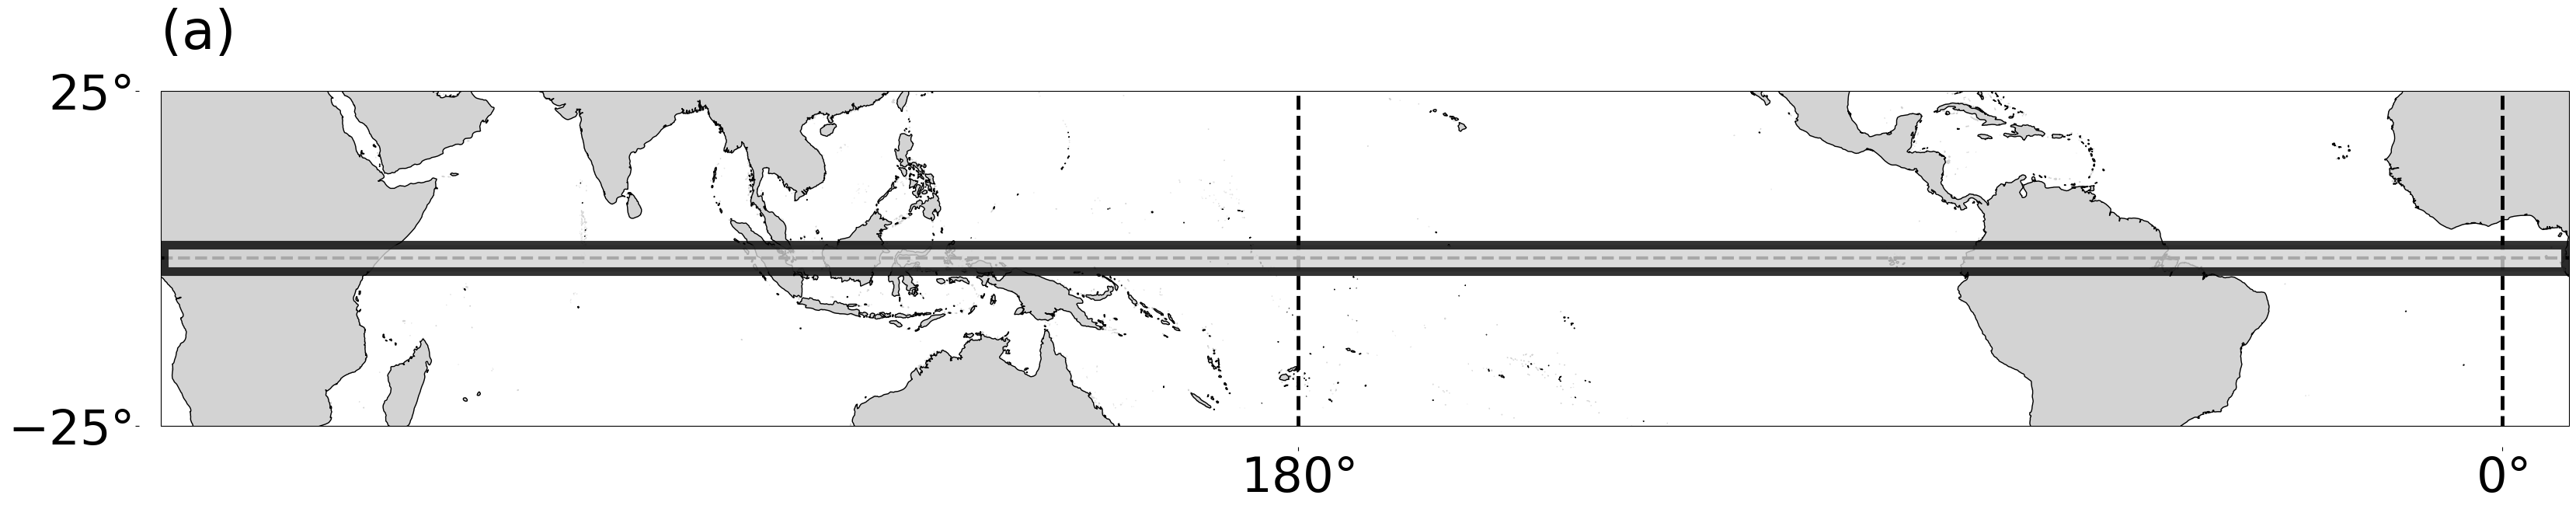

In [27]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
SIZE = 45
FONTSIZE = SIZE
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE

degrees_left_box_bound = -40
degrees_right_box_bound = 40
degrees_lower_box_bound = -25
degrees_upper_box_bound = 25

new_degrees_left_box_bound = degrees_left_box_bound + 180
new_degrees_right_box_bound = degrees_right_box_bound + 180

print('Region: ', degrees_lower_box_bound, degrees_upper_box_bound, new_degrees_left_box_bound, new_degrees_right_box_bound)

fig = plt.figure(figsize=(40, 25), facecolor='w', edgecolor='k')
gs = GridSpec(1, 1)

ax1 = plt.subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=190))
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'))
ax1.coastlines(color='black')
ax1.set_aspect(1)
ax1.set_ylim(degrees_lower_box_bound, degrees_upper_box_bound)
ax1.hlines(0, -180, 180, linestyles='dashed', linewidth=3, color="black", alpha=1, zorder=2)
ax1.vlines(-10, -90, 90, linestyles='dashed', linewidth=3.5, color="black", alpha=1, zorder=2)
ax1.vlines(170, -90, 90, linestyles='dashed', linewidth=3.5, color="black", alpha=1, zorder=2)
ax1.add_patch(Rectangle((-179.5, -2), 359, np.abs(np.diff([-2, 2])), 
                        edgecolor='black', 
                        facecolor='lightgrey', 
                        lw=8, 
                        alpha=0.8,
                        zorder=10))

ax1.set_yticks([degrees_lower_box_bound,degrees_upper_box_bound], crs=ccrs.PlateCarree())
ax1.set_yticklabels(['$-25°$', '$25°$'])
ax1.set_xticks([0, 180],crs=ccrs.PlateCarree())
ax1.set_xticklabels(['$0°$', '$180°$'])
ax1.spines[['left', 'bottom']].set_position(('outward',20))

ax1.annotate("(a)", xy=(0, 1.25), xycoords='axes fraction', fontsize=SIZE+5, ha='left', va='top')

filename = f'fig_00_01.png'
filepath = datapath+'figs/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=800)

plt.show()

In [ ]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
SIZE = 22
FONTSIZE = SIZE
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE

# Create windrose plot
ax = WindroseAxes.from_ax()

# Plot data on the windrose
ax.bar(WD_merid_mean.values.ravel(), WS_merid_mean.values.ravel(), opening=0.8, normed=True, edgecolor='white', cmap=cm.viridis, bins=np.arange(0, 10, 2))

# Customize radial (y-axis) labels to specific angles
custom_labels = [30, 60, 120, 150, 210, 240, 300, 330]
ax.set_thetagrids(custom_labels, labels=[f"{label}°" for label in custom_labels], fontsize=FONTSIZE)

# Remove the default compass labels
ax.set_xticklabels([r'$60°$', r'$30°$', r'$330°$', r'$300°$', r'$240°$', r'$210°$', r'$150°$', r'$120°$'], fontsize=FONTSIZE)
ax.tick_params(axis='x', pad=25)

# Adjust y-axis tick labels
ax.set_yticks([5, 10, 15, 20])
ax.set_yticklabels(['5%', '10%', '15%', '20%'], fontsize=FONTSIZE)

ax.annotate("(b)", xy=(-0.2, 1.05), xycoords='axes fraction', fontsize=FONTSIZE+5, ha='left', va='top')

# Customize legend
legend = ax.legend(title=r"Wind Speed / ms$^{-1}$", fontsize=FONTSIZE, title_fontsize=FONTSIZE, loc='lower left', bbox_to_anchor=(1.15, 0), frameon=False)

# Format legend labels
for label in legend.get_texts():
    match = re.match(r'\[(\d+\.\d+) : (\d+\.\d+)\)', label.get_text())
    match1 = re.match(r'(\>\d+\.\d+)', label.get_text())
    if match:
        lower_bound = int(float(match.group(1)))
        upper_bound = int(float(match.group(2)))
        label.set_text(f'[{lower_bound} : {upper_bound})')
    elif match1:
        bound = 10
        label.set_text(f'>{bound}')

for text in legend.get_texts():
    text.set_fontsize(FONTSIZE)


filename = f'fig_00_00_revised.png'
filepath = datapath+'figs/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=800)

plt.show()

In [ ]:
from PIL import Image

# Paths to your PNG files
png1_path = datapath + 'figs/fig_00_01.png'
png2_path = datapath + 'figs/fig_00_00_revised.png'
output_image = "figs/fig_00_01_revised.png"

# Open both images
image1 = Image.open(png1_path)
image2 = Image.open(png2_path)

# Resize the first image to reduce its size (e.g., 80% of its original size)
scale_factor = 0.5
width1, height1 = image1.size
new_width1 = int(width1 * scale_factor)
new_height1 = int(height1 * scale_factor)
image1 = image1.resize((new_width1, new_height1), Image.ANTIALIAS)

# Get the dimensions of the resized image1 and original image2
width1, height1 = image1.size
width2, height2 = image2.size

# Create a new image with enough space for both images
new_width = max(width1, width2)
new_height = height1 + height2 + 300  # Add some spacing between images

# Create a new blank image with the combined size and white background
new_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))  # White background

# Paste the resized image1 at the top
new_image.paste(image1, ((new_width - width1) // 2, 0))  # Center horizontally

# Define an offset for the second image
offset_x = 1475  # Adjust this value to move the image right or left (positive = right, negative = left)

# Paste image2 below image1 and slightly offset to the right
new_image.paste(image2, (((new_width - width2) // 2) + offset_x, height1 + 250))  # Adjust x with offset_x

# Rescale the entire combined image
final_scale_factor = 0.8
final_width = int(new_width * final_scale_factor)
final_height = int(new_height * final_scale_factor)
rescaled_image = new_image.resize((final_width, final_height), Image.ANTIALIAS)

# Save the rescaled image
rescaled_image.save(output_image)

print(f"Images merged and rescaled successfully into {output_image}")
